In [38]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

## Loading Data

In [39]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

In [40]:
ssh_hf_1h

<xarray.Dataset> Size: 11MB
Dimensions:       (y: 853, x: 788)
Coordinates:
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-10T00:30:00
Dimensions without coordinates: y, x
Data variables:
    ssh_hf        (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan

In [41]:
# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

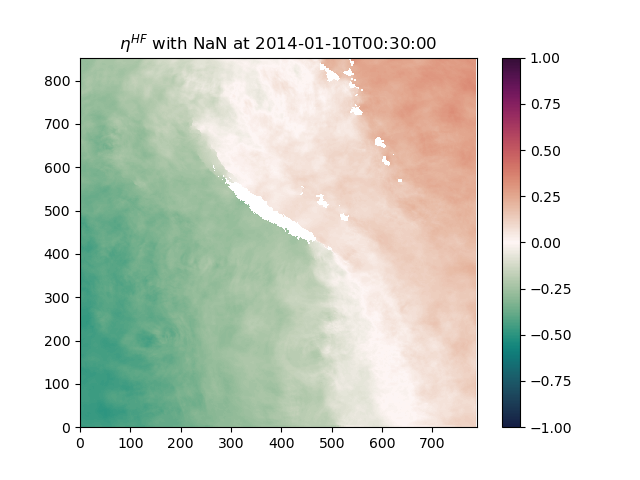

In [42]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
plt.colorbar()
plt.title('$\eta^{HF}$ with NaN at 2014-01-10T00:30:00')
plt.show()

## Filling NaNs

In [43]:
# Define the axes correctly using pyinterp.core.Axis
x_axis = pyinterp.core.Axis(ssh_hf_1h_masked.x.values, is_circle=True)
y_axis = pyinterp.core.Axis(ssh_hf_1h_masked.y.values, is_circle=True)
# Prepare the grid using pyinterp.Grid2D
grid = pyinterp.Grid2D(y_axis, x_axis, ssh_hf_1h['ssh_hf'].values)

In [44]:
has_converged, ssh_hf_1h_masked_filled = fill.gauss_seidel(grid,num_threads=16)

In [45]:
# plt.figure()
# plt.pcolormesh(ssh_hf_1h_masked_filled, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
# plt.colorbar()
# plt.title('$\eta^{HF}$ filled at 2014-01-10T00:30:00')
# plt.show()

## Extract Barothropic Tide

### Paving

In [46]:
# Compute mean of dx and dy and convert to plain numbers # Ensure nx and ny are integers
nx = int(ssh_hf_1h['ssh_hf'].shape[1]) 
ny = int(ssh_hf_1h['ssh_hf'].shape[0])

In [47]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [48]:
ssh_hf_1h_masked_filled_extended = extend(ssh_hf_1h_masked_filled,nx,ny)

In [49]:
# plt.figure()
# plt.pcolormesh(ssh_hf_1h_masked_filled_extended, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
# plt.colorbar()
# plt.title('$\eta^{HF}$ paved at 2014-01-10T00:30:00')
# plt.show()

### Wave Numbers

In [50]:
dx = ssh_hf_1h['lon'].diff(dim='x')  # Change in longitude along x-axis
dy = ssh_hf_1h['lat'].diff(dim='y')  # Change in latitude along y-axis
dx_mean = float(dx.mean().values)  # Ensure this is a scalar float
dy_mean = float(dy.mean().values)  # Ensure this is a scalar float

In [51]:
# dx_mean = 2000
# dy_mean = 2000

In [52]:
kx = np.fft.fftfreq(3*nx,dx_mean) # km
ky = np.fft.fftfreq(3*ny,dy_mean) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2) #is it ok?

In [53]:
# plt.figure()
# plt.pcolormesh(wavenum2D)
# plt.colorbar()
# plt.title('Wavenumber 2D')
# plt.show()

### Low Pass Filter

In [54]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [55]:
lambda_bar = 0.004 # but the original value is 400?
lowpass_bar = lowpass(lambda_bar,nx,ny,wavenum2D)

# plt.figure()
# plt.pcolormesh(lowpass_bar)
# plt.colorbar()
# plt.show()

### Create Spatial Window

In [56]:
def gaspari_cohn(array,distance,center):
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [57]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [58]:
window = create_spatial_window(nx,ny)

In [59]:
ssh_hf_1h_masked_filled_extended_windowed = ssh_hf_1h_masked_filled_extended * window

In [60]:
# plt.figure()
# plt.pcolormesh(ssh_hf_1h_masked_filled_extended_windowed, cmap=cmocean.cm.curl, vmin=-1, vmax=1)
# plt.colorbar()
# plt.title('$\eta^{HF}$ paved and windowed at 2014-01-10T00:30:00')
# plt.show()

### Filtering

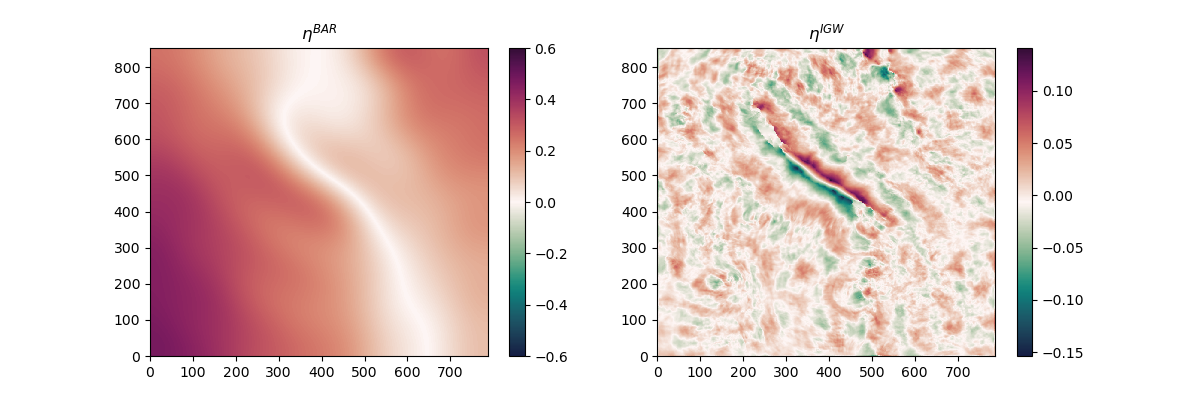

In [61]:
lambda_bar = 2.6
lowpass_bar = lowpass(lambda_bar, nx, ny, wavenum2D)

ssh_hf_freq = fp.fft2(ssh_hf_1h_masked_filled_extended_windowed)
ssh_freq_filtered = lowpass_bar * ssh_hf_freq
ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny, nx:2*nx]

ssh_igw = ssh_hf_1h_masked_filled - ssh_filtered

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
im1 = axes[0].pcolormesh(np.abs(ssh_filtered), cmap=cmocean.cm.curl
                         ,vmin=-0.6, vmax=0.6
                         )
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('$\eta^{BAR}$')
im2 = axes[1].pcolormesh(ssh_igw, cmap=cmocean.cm.curl)
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('$\eta^{IGW}$')
plt.show()

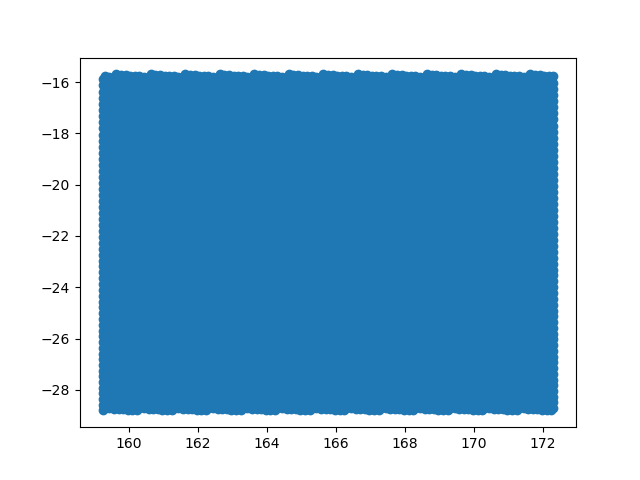

In [62]:
plt.figure()
plt.scatter(ssh_hf_1h_masked['lon'].values.flatten()[::60], ssh_hf_1h_masked['lat'].values.flatten()[::60])
plt.show()

In [63]:
ssh_hf_1h_masked['lon'].values.flatten()[::60].shape

(11203,)